# Analysis of RV-CGP behaviour

Goal of this notebook is to analyze how many possible values the CMA-ES go through.

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

import tengp
import numpy as np
from gpbenchmarks import get_data
from sklearn.metrics import mean_squared_error
import random

def pdivide(x, y):
    return np.divide(x, y, out=np.copy(x), where=x!=0)

def plog(x, _):
    return np.log(x, out=np.copy(x), where=x>0)

def psin(x, _):
    return np.sin(x)

def pcos(x, _):
    return np.cos(x)

def pow2(x):
    return x**2

def pow3(x):
    return x**3


funset = tengp.FunctionSet()
funset.add(np.add, 2)
funset.add(np.subtract, 2)
funset.add(np.multiply, 2)
funset.add(pdivide, 2)

X, y = get_data('nguyenf4', 20, -1, 1)
X = np.c_[np.ones(len(X)), X]

params = tengp.Parameters(2, 1, 1, 10, funset, real_valued=True)

builder = tengp.individual.IndividualBuilder(params)
bounds = builder.create().bounds[:]
individuals = []

In [16]:
def cost_function_no_log(G):
    #scaled = [linscale(x, 0, b) for x, b in zip(G, bounds)]
    clipped = []
    for gene, bound in zip(G, bounds):
        if gene < 0:
            clipped.append(0)
        elif gene > bound:
            clipped.append(bound)
        else:
            clipped.append(gene)
    individuals.append(clipped)    
    individual = tengp.individual.NPIndividual(clipped, bounds, params)
    pred = individual.transform(X)
    
    try:
        out = mean_squared_error(pred, y)
    except ValueError:
        out = np.inf
    return (out, )

def cost_function(G):
    #scaled = [linscale(x, 0, b) for x, b in zip(G, bounds)]
    clipped = []
    for gene, bound in zip(G, bounds):
        if gene < 0:
            clipped.append(0)
        elif gene > bound:
            clipped.append(bound)
        else:
            clipped.append(gene)
    individuals.append(clipped)    
    individual = tengp.individual.NPIndividual(clipped, bounds, params)
    pred = individual.transform(X)
    
    try:
        out = mean_squared_error(pred, y)
    except ValueError:
        out = np.inf
    return (out, )

In [17]:
from array import array
from deap import creator, base, tools, cma, algorithms

sigma = 0.05

creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
creator.create('Individual', array, typecode='f', fitness=creator.FitnessMin)

def run_strategy(sigma):
    global individuals
    individuals = []
    
    strategy = cma.Strategy(centroid=[np.random.uniform(0, b) for b in bounds], sigma=sigma)

    toolbox = base.Toolbox()
    toolbox.register('evaluate', cost_function)
    toolbox.register("generate", strategy.generate, creator.Individual)
    toolbox.register("update", strategy.update)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)

    pop, log = algorithms.eaGenerateUpdate(toolbox, ngen=250, stats=stats, halloffame=hof, verbose=False)
    
    
    
    return hof[0], individuals

/home/jarino/anaconda3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/jarino/anaconda3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


# Sigma 0.05

In [23]:
best, all_individuals = run_strategy(0.05)

In [24]:
all_individuals = np.array(all_individuals)
print('bounds min max diff')
mins = np.floor(all_individuals.min(axis=0))
maxs = np.ceil(all_individuals.max(axis=0))
print(np.c_[np.array(bounds), mins, maxs, maxs - mins])
print(f'average range searched {np.mean(maxs - mins)}, sigma={sigma}')

bounds min max diff
[[ 3.  0.  2.  2.]
 [ 1.  0.  1.  1.]
 [ 1.  0.  1.  1.]
 [ 3.  1.  3.  2.]
 [ 2.  0.  1.  1.]
 [ 2.  0.  1.  1.]
 [ 3.  1.  3.  2.]
 [ 3.  1.  3.  2.]
 [ 3.  1.  3.  2.]
 [ 3.  2.  3.  1.]
 [ 4.  0.  2.  2.]
 [ 4.  2.  4.  2.]
 [ 3.  0.  3.  3.]
 [ 5.  2.  4.  2.]
 [ 5.  4.  5.  1.]
 [ 3.  0.  1.  1.]
 [ 6.  2.  5.  3.]
 [ 6.  2.  5.  3.]
 [ 3.  0.  2.  2.]
 [ 7.  4.  7.  3.]
 [ 7.  0.  3.  3.]
 [ 3.  0.  1.  1.]
 [ 8.  2.  4.  2.]
 [ 8.  4.  6.  2.]
 [ 3.  1.  3.  2.]
 [ 9.  3.  5.  2.]
 [ 9.  0.  2.  2.]
 [ 3.  0.  1.  1.]
 [10.  0.  3.  3.]
 [10.  8. 10.  2.]
 [11.  5.  8.  3.]]
average range searched 1.935483870967742, sigma=0.05


In [46]:
res = []
for _ in range(10):
    print(_, end=' ')
    best, _ = run_strategy(0.05)
    res.append(cost_function_no_log(best))

0 1 

/home/jarino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:148: RuntimeWarning: invalid value encountered in add
  current_node.value = lower_function + upper_function
/home/jarino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:146: RuntimeWarning: invalid value encountered in multiply
  upper_function = a*( fun_upper((1-c) * self.nodes[c_lower].value, c * self.nodes[c_upper].value))
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:144: RuntimeWarning: invalid value encountered in subtract
  lower_function = (1-a)*( fun_lower((1-b) * self.nodes[b_lower].value, b*self.nodes[b_upper].value))


2 3 

/home/jarino/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


4 5 6 7 8 9 

1.1505771008376697 0.9598153214425751 0.5281686650678531


(0, 3)

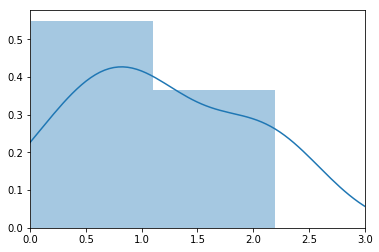

In [47]:
_, ax = plt.subplots()
print(np.mean(res), np.median(res), np.var(res))
sns.distplot(res, ax=ax);
ax.set_xlim(0, 3)

## Sigma 0.5

In [32]:
best, all_individuals = run_strategy(0.5)

/home/jarino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:144: RuntimeWarning: invalid value encountered in multiply
  lower_function = (1-a)*( fun_lower((1-b) * self.nodes[b_lower].value, b*self.nodes[b_upper].value))
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:148: RuntimeWarning: invalid value encountered in add
  current_node.value = lower_function + upper_function
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:146: RuntimeWarning: invalid value encountered in multiply
  upper_function = a*( fun_upper((1-c) * self.nodes[c_lower].value, c * self.nodes[c_upper].value))
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:146: RuntimeWarning: invalid value encountered in subtract
  upper_function = a*( fun_upper((1-c) * self.nodes[c_lower].value, c * self.nodes[c_upper].val

In [34]:
all_individuals = np.array(all_individuals)
print('bounds min max diff')
mins = np.floor(all_individuals.min(axis=0))
maxs = np.ceil(all_individuals.max(axis=0))
print(np.c_[np.array(bounds), mins, maxs, maxs - mins])
print(f'average range searched {np.mean(maxs - mins)}, sigma={0.5}')

bounds min max diff
[[ 3.  0.  3.  3.]
 [ 1.  0.  1.  1.]
 [ 1.  0.  1.  1.]
 [ 3.  0.  3.  3.]
 [ 2.  0.  2.  2.]
 [ 2.  0.  2.  2.]
 [ 3.  0.  3.  3.]
 [ 3.  0.  3.  3.]
 [ 3.  0.  3.  3.]
 [ 3.  0.  3.  3.]
 [ 4.  0.  4.  4.]
 [ 4.  0.  3.  3.]
 [ 3.  0.  3.  3.]
 [ 5.  2.  5.  3.]
 [ 5.  0.  5.  5.]
 [ 3.  0.  3.  3.]
 [ 6.  0.  5.  5.]
 [ 6.  1.  4.  3.]
 [ 3.  0.  3.  3.]
 [ 7.  5.  7.  2.]
 [ 7.  2.  6.  4.]
 [ 3.  0.  3.  3.]
 [ 8.  0.  3.  3.]
 [ 8.  4.  8.  4.]
 [ 3.  0.  3.  3.]
 [ 9.  0.  2.  2.]
 [ 9.  0.  4.  4.]
 [ 3.  0.  3.  3.]
 [10.  1.  6.  5.]
 [10.  7. 10.  3.]
 [11.  6. 10.  4.]]
average range searched 3.096774193548387, sigma=0.5


In [48]:
res = []
for _ in range(10):
    print(_, end=' ')
    best, _ = run_strategy(0.5)
    res.append(cost_function_no_log(best))

0 

/home/jarino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/jarino/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:146: RuntimeWarning: invalid value encountered in multiply
  upper_function = a*( fun_upper((1-c) * self.nodes[c_lower].value, c * self.nodes[c_upper].value))
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:148: RuntimeWarning: invalid value encountered in add
  current_node.value = lower_function + upper_function
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:146: RuntimeWarning: invalid value encountered in subtract
  upper_function = a*( fun_upper((1-c) * self.nodes[c_lower].value, c * self.nodes[c_upper].value))
/home/jarino/anaconda3/lib/pyth

1 2 3 4 

/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:146: RuntimeWarning: invalid value encountered in add
  upper_function = a*( fun_upper((1-c) * self.nodes[c_lower].value, c * self.nodes[c_upper].value))


5 6 7 8 9 

1.2481127082790635 1.0405865666193015 0.5574951462324835


(0, 3)

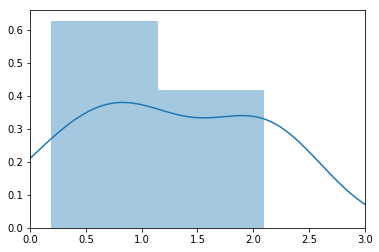

In [49]:
_, ax = plt.subplots()
print(np.mean(res), np.median(res), np.var(res))
sns.distplot(res, ax=ax);
ax.set_xlim(0, 3)

## Sigma 1

In [50]:
best, all_individuals = run_strategy(1)

/home/jarino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:146: RuntimeWarning: invalid value encountered in multiply
  upper_function = a*( fun_upper((1-c) * self.nodes[c_lower].value, c * self.nodes[c_upper].value))
/home/jarino/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:118: RuntimeWarning: invalid value encountered in add
  value = (1-coeff)*self.nodes[lower].value + coeff*self.nodes[upper].value


In [52]:
all_individuals = np.array(all_individuals)
print('bounds min max diff')
mins = np.floor(all_individuals.min(axis=0))
maxs = np.ceil(all_individuals.max(axis=0))
print(np.c_[np.array(bounds), mins, maxs, maxs - mins])
print(f'average range searched {np.mean(maxs - mins)}, sigma={1}')

bounds min max diff
[[ 3.  0.  3.  3.]
 [ 1.  0.  1.  1.]
 [ 1.  0.  1.  1.]
 [ 3.  0.  3.  3.]
 [ 2.  0.  2.  2.]
 [ 2.  0.  2.  2.]
 [ 3.  0.  3.  3.]
 [ 3.  0.  3.  3.]
 [ 3.  0.  3.  3.]
 [ 3.  0.  3.  3.]
 [ 4.  0.  4.  4.]
 [ 4.  0.  4.  4.]
 [ 3.  0.  3.  3.]
 [ 5.  0.  5.  5.]
 [ 5.  0.  5.  5.]
 [ 3.  0.  3.  3.]
 [ 6.  0.  6.  6.]
 [ 6.  0.  6.  6.]
 [ 3.  0.  3.  3.]
 [ 7.  0.  7.  7.]
 [ 7.  0.  7.  7.]
 [ 3.  0.  3.  3.]
 [ 8.  0.  8.  8.]
 [ 8.  0.  2.  2.]
 [ 3.  0.  3.  3.]
 [ 9.  0.  9.  9.]
 [ 9.  0.  9.  9.]
 [ 3.  0.  3.  3.]
 [10.  2. 10.  8.]
 [10.  6. 10.  4.]
 [11.  0.  6.  6.]]
average range searched 4.258064516129032, sigma=1


In [53]:
res = []
for _ in range(10):
    print(_, end=' ')
    best, _ = run_strategy(1)
    res.append(cost_function_no_log(best))

0 

/home/jarino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/jarino/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:146: RuntimeWarning: invalid value encountered in multiply
  upper_function = a*( fun_upper((1-c) * self.nodes[c_lower].value, c * self.nodes[c_upper].value))
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:118: RuntimeWarning: invalid value encountered in add
  value = (1-coeff)*self.nodes[lower].value + coeff*self.nodes[upper].value


1 

/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:144: RuntimeWarning: invalid value encountered in multiply
  lower_function = (1-a)*( fun_lower((1-b) * self.nodes[b_lower].value, b*self.nodes[b_upper].value))


2 

/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:144: RuntimeWarning: invalid value encountered in add
  lower_function = (1-a)*( fun_lower((1-b) * self.nodes[b_lower].value, b*self.nodes[b_upper].value))
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:146: RuntimeWarning: invalid value encountered in subtract
  upper_function = a*( fun_upper((1-c) * self.nodes[c_lower].value, c * self.nodes[c_upper].value))
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:148: RuntimeWarning: invalid value encountered in add
  current_node.value = lower_function + upper_function
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:144: RuntimeWarning: invalid value encountered in subtract
  lower_function = (1-a)*( fun_lower((1-b) * self.nodes[b_lower].value, b*self.nodes[b_upper].value))
/home/jarino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_pa

3 4 

/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:146: RuntimeWarning: invalid value encountered in add
  upper_function = a*( fun_upper((1-c) * self.nodes[c_lower].value, c * self.nodes[c_upper].value))


5 6 7 8 9 

1.2948754227895074 1.154359922423921 0.2006137985645895


(0, 3)

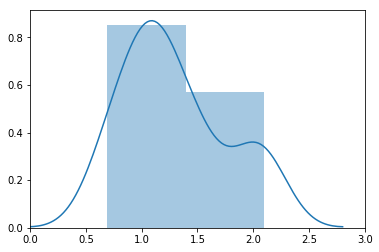

In [54]:
_, ax = plt.subplots()
print(np.mean(res), np.median(res), np.var(res))
sns.distplot(res, ax=ax);
ax.set_xlim(0, 3)

# Sigma 0.01

In [60]:
best, all_individuals = run_strategy(0.01)

/home/jarino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:148: RuntimeWarning: invalid value encountered in add
  current_node.value = lower_function + upper_function


In [61]:
all_individuals = np.array(all_individuals)
print('bounds min max diff')
mins = np.floor(all_individuals.min(axis=0))
maxs = np.ceil(all_individuals.max(axis=0))
print(np.c_[np.array(bounds), mins, maxs, maxs - mins])
print(f'average range searched {np.mean(maxs - mins)}, sigma={0.01}')

bounds min max diff
[[ 3.  1.  3.  2.]
 [ 1.  0.  1.  1.]
 [ 1.  0.  1.  1.]
 [ 3.  0.  1.  1.]
 [ 2.  0.  2.  2.]
 [ 2.  1.  2.  1.]
 [ 3.  2.  3.  1.]
 [ 3.  1.  3.  2.]
 [ 3.  1.  3.  2.]
 [ 3.  0.  1.  1.]
 [ 4.  1.  2.  1.]
 [ 4.  0.  1.  1.]
 [ 3.  1.  2.  1.]
 [ 5.  2.  3.  1.]
 [ 5.  1.  2.  1.]
 [ 3.  2.  3.  1.]
 [ 6.  3.  5.  2.]
 [ 6.  2.  4.  2.]
 [ 3.  0.  1.  1.]
 [ 7.  1.  3.  2.]
 [ 7.  3.  5.  2.]
 [ 3.  0.  1.  1.]
 [ 8.  6.  8.  2.]
 [ 8.  4.  6.  2.]
 [ 3.  0.  2.  2.]
 [ 9.  2.  4.  2.]
 [ 9.  5.  6.  1.]
 [ 3.  2.  3.  1.]
 [10.  6.  8.  2.]
 [10.  6.  8.  2.]
 [11.  4.  5.  1.]]
average range searched 1.4516129032258065, sigma=0.01


In [62]:
res = []
for _ in range(10):
    print(_, end=' ')
    best, _ = run_strategy(0.01)
    res.append(cost_function_no_log(best))

0 1 2 3 4 

/home/jarino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:148: RuntimeWarning: invalid value encountered in add
  current_node.value = lower_function + upper_function
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:146: RuntimeWarning: invalid value encountered in multiply
  upper_function = a*( fun_upper((1-c) * self.nodes[c_lower].value, c * self.nodes[c_upper].value))
/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:144: RuntimeWarning: invalid value encountered in add
  lower_function = (1-a)*( fun_lower((1-b) * self.nodes[b_lower].value, b*self.nodes[b_upper].value))


5 6 7 

/home/jarino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


8 9 

/mnt/c/Users/jarinov-notas/dev/tengp/tengp/individual.py:118: RuntimeWarning: invalid value encountered in add
  value = (1-coeff)*self.nodes[lower].value + coeff*self.nodes[upper].value


1.077233025314435 0.7348781031799674 0.9024412542695497


(0, 3)

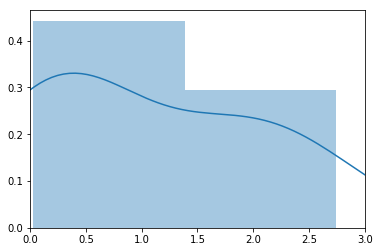

In [63]:
_, ax = plt.subplots()
print(np.mean(res), np.median(res), np.var(res))
sns.distplot(res, ax=ax);
ax.set_xlim(0, 3)